# Sales Prediction for Big Mart Outlets

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.
Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly. 



**Data Dictionary**
We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.



**Train file**: CSV containing the item outlet information with sales value

Variable :: Description</br>
Item_Identifier :: Unique product ID</br>
Item_Weight :: Weight of product</br>
Item_Fat_Content :: Whether the product is low fat or not</br>
Item_Visibility :: The % of total display area of all products in a store allocated to the particular product</br>
Item_Type :: The category to which the product belongs</br>
Item_MRP :: Maximum Retail Price (list price) of the product</br>
Outlet_Identifier :: Unique store ID</br>
Outlet_Establishment_Year :: The year in which store was established</br>
Outlet_Size :: The size of the store in terms of ground area covered</br>
Outlet_Location_Type :: The type of city in which the store is located</br>
Outlet_Type :: Whether the outlet is just a grocery store or some sort of supermarket</br>
Item_Outlet_Sales :: Sales of the product in the particular store. This is the outcome variable to be predicted.</br>
 

**Test file**: CSV containing item outlet combinations for which sales need to be forecasted

Variable :: Description</br>
Item_Identifier :: Unique product ID</br>
Item_Weight :: Weight of product</br>
Item_Fat_Content :: Whether the product is low fat or not</br>
Item_Visibility :: The % of total display area of all products in a store allocated to the particular product</br>
Item_Type :: The category to which the product belongs</br>
Item_MRP :: Maximum Retail Price (list price) of the product</br>
Outlet_Identifier :: Unique store ID</br>
Outlet_Establishment_Year :: The year in which store was established</br>
Outlet_Size :: The size of the store in terms of ground area covered</br>
Outlet_Location_Type :: The type of city in which the store is located</br>
Outlet_Type :: Whether the outlet is just a grocery store or some sort of supermarket</br>

**IMPORTING THE IMPORTANT LIBERARIES**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sma
import statsmodels.formula.api as sfa
from statsmodels.api import OLS, add_constant
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler, power_transform, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

**IMPORTING AND UNDERSTANDING THE DATA**

In [2]:
train=pd.read_csv('trainBM.csv')
test=pd.read_csv('testBM.csv')
sub=pd.read_csv('SampleSubmissionBM.csv')
df=pd.concat([train,test],ignore_index=True)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
#shape of the Dataset
df.shape,(train.shape[0]+test.shape[0])

((14204, 12), 14204)

In [4]:
#Basic Info of the Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.3+ MB


In [5]:
#displaying all the columns and rows
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',200)
#Checking the categories in each of the columns
for i in df.columns:
    print(i,'::',df[i].nunique())
    print()
    print(df[i].value_counts(normalize=True))
    print('\n--------------------------------')
    
#Inferences::
#1. Correct the spellings and mismatch of data. It can be encoded using OHE.Item_Fat_Content.
#2. Bin the Item_Type. It can also be encoded using frequency and made a new feature.
#3. Outlet_Establishment_Year is a categorical column. 
#It can be used to find the Vintage status of the outlet.
#4. Frequency Encode Outlet_Size.
#5. Outlet_Location_Type & Outlet_Type can be encoded using Label encoding/OHE.
#6. There are missing Values.

Item_Identifier :: 1559

FDU15    0.000704
FDS25    0.000704
FDA38    0.000704
FDW03    0.000704
FDJ10    0.000704
           ...   
FDR51    0.000493
FDM52    0.000493
DRN11    0.000493
FDH58    0.000493
NCW54    0.000493
Name: Item_Identifier, Length: 1559, dtype: float64

--------------------------------
Item_Weight :: 415

17.600    0.011475
12.150    0.010795
10.500    0.010455
13.650    0.009775
11.800    0.009605
            ...   
7.640     0.000595
5.905     0.000595
7.850     0.000510
4.615     0.000510
9.035     0.000510
Name: Item_Weight, Length: 415, dtype: float64

--------------------------------
Item_Fat_Content :: 5

Low Fat    0.597367
Regular    0.339623
LF         0.036750
reg        0.013729
low fat    0.012532
Name: Item_Fat_Content, dtype: float64

--------------------------------
Item_Visibility :: 13006

0.000000    0.061884
0.076841    0.000211
0.077011    0.000211
0.077169    0.000211
0.076792    0.000211
              ...   
0.162572    0.000070
0.014826    

In [6]:
#Checking the null values
df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending=False)

#Check columns related to Outlet_Size and Item_Weight and fill the missing values.

Item_Outlet_Sales    5681
Outlet_Size          4016
Item_Weight          2439
dtype: int64

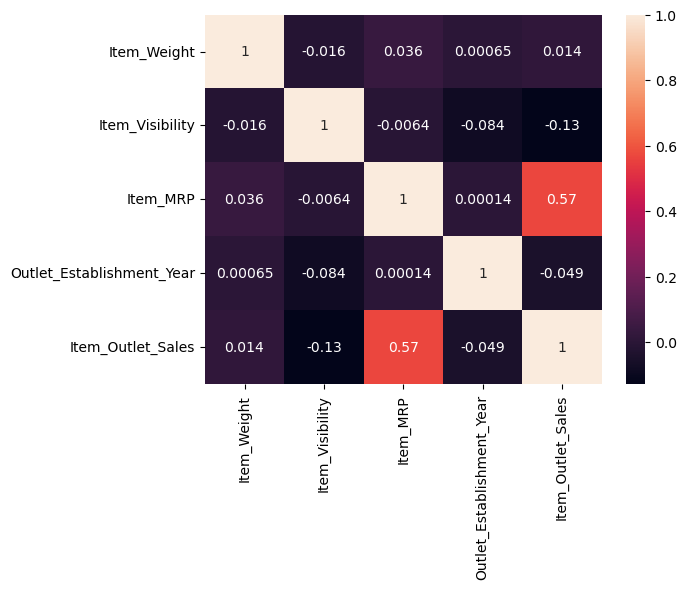

In [7]:
#Checking correlation of all the columns with each other
sns.heatmap(df.corr(),annot=True)
plt.show()

#There no strong correlation among the predictors and target variable.
#Item MRP might be of significance.

**DATA CLEANING**

In [8]:
#Correcting some spelling mismatch that were present
df['Item_Fat_Content'].replace({'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'}, inplace=True)

In [9]:
#Dividing the variables in categorical and Numerical Variables
catcols=df.select_dtypes(exclude=np.number).columns
numcols=df.select_dtypes(include=np.number).columns

#replacing some displaced categorical columns to catcols
catcols=['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Establishment_Year', 'Outlet_Type']
numcols=['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']

**UNIVARIATE ANALYSIS FOR CATEGORICAL VARIABLES**

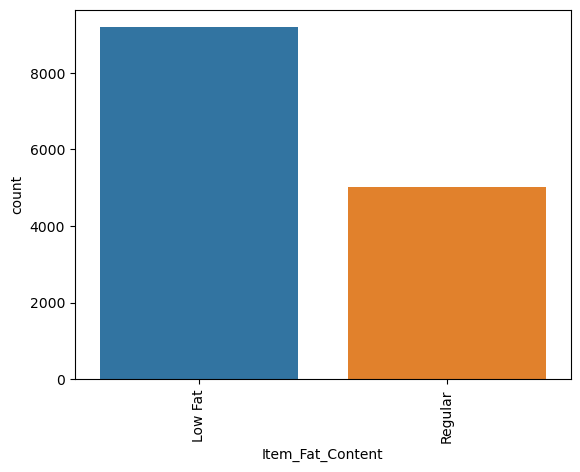

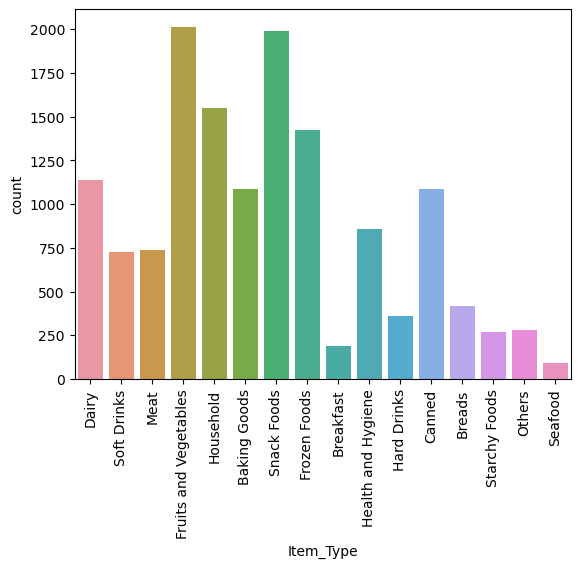

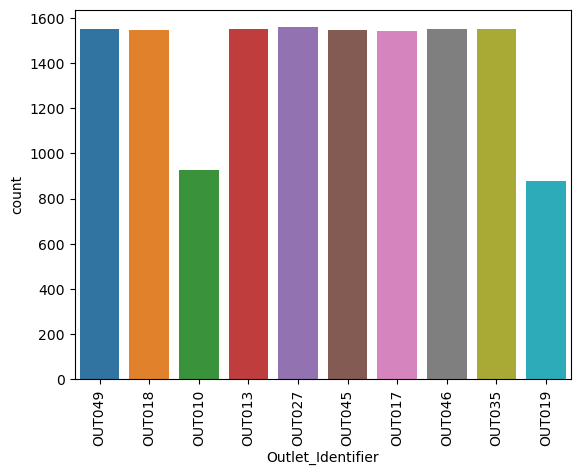

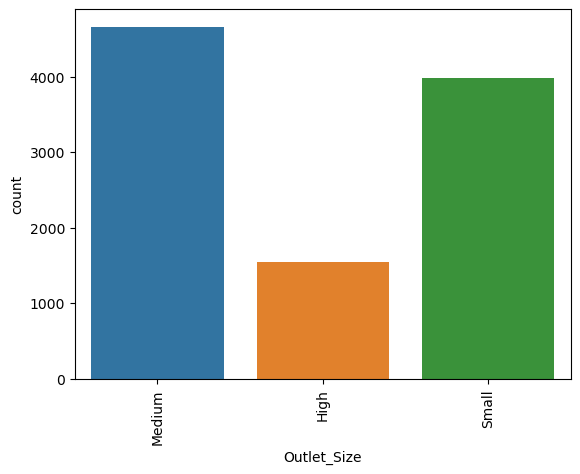

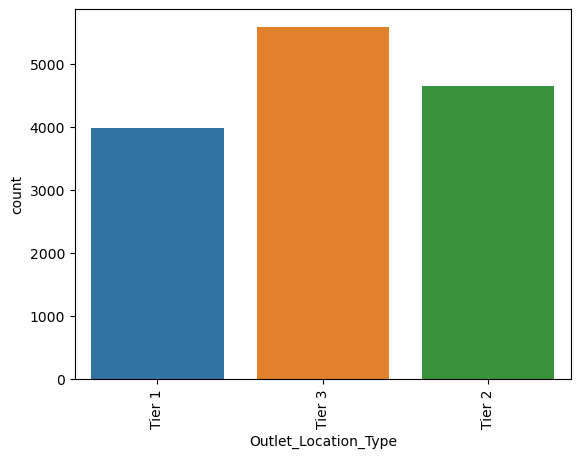

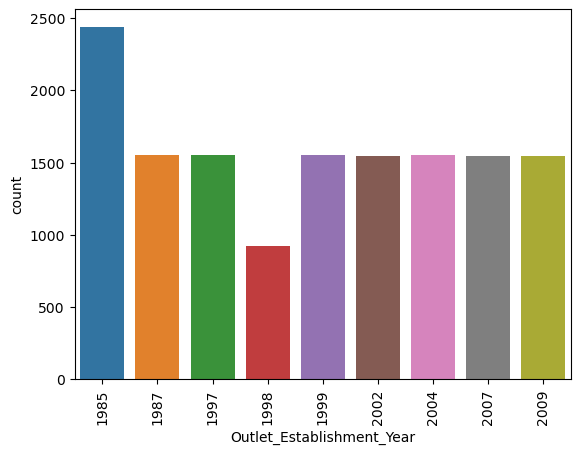

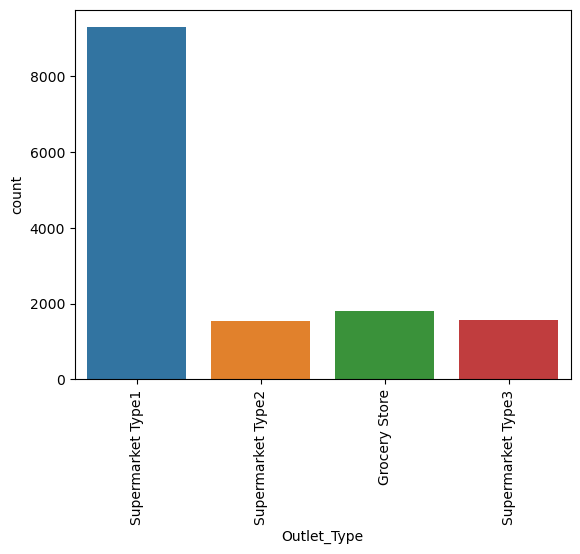

In [10]:
for i in catcols:
    if df[i].nunique()<100:
        sns.countplot(df[i])
        plt.xticks(rotation=90)
        plt.show()

**INFERENCES OF UNIVARIATE ANALYSIS OF CATEGORICAL VARIABLES**
* Low Fat Items are more popular than regular items.
* Snack Foods and Fruits and Vegetables are the highest selling Items. Whereas Seafood and Breakfast sell the least.
* Outlet 10 and 19 are least performing outlets.
* Maximum outlets are Medium size and High Size outlets are minimum.
* Maximum outlets are in Tier 3 Cities.
* Maximum outlets were setup in either 1985.
* Maximum Outlets are SuperMarket Type1.

**UNIVARIATE ANALYSIS FOR NUMERICAL VARIIABLES**

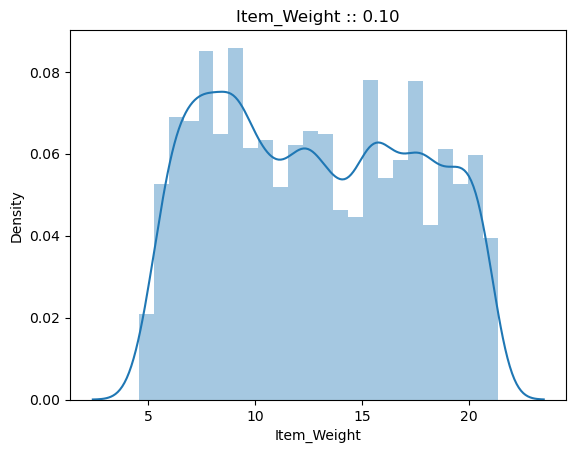

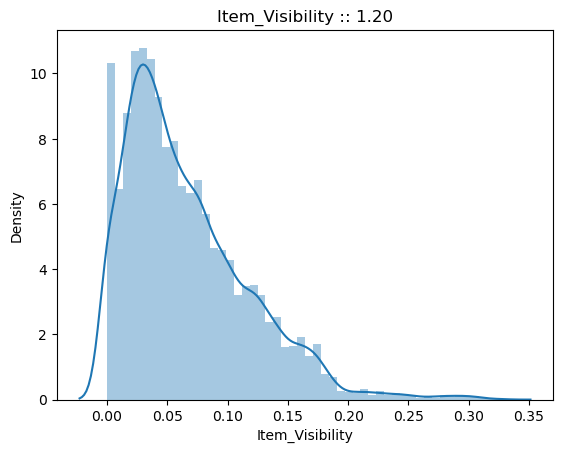

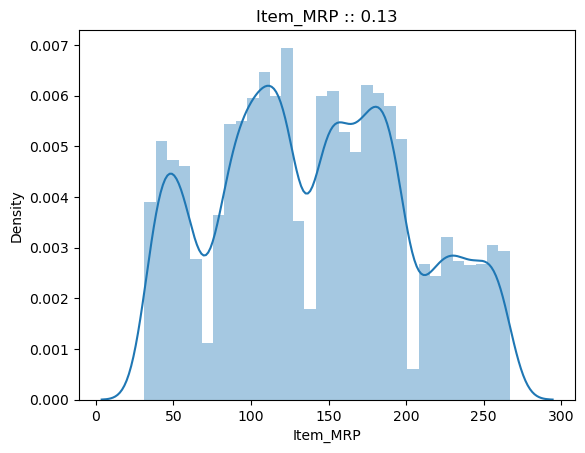

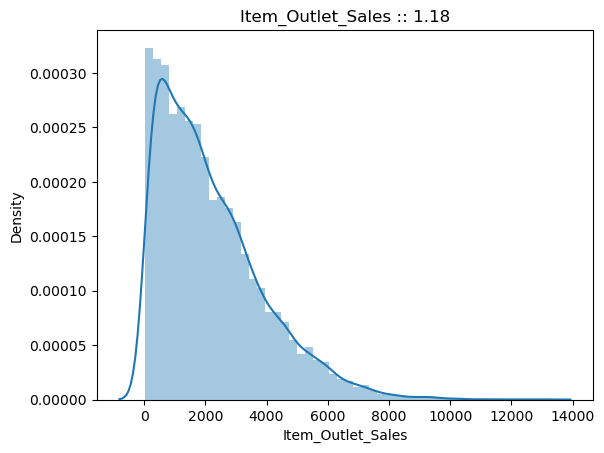

In [11]:
for i in numcols:
    sns.distplot(df[i])
    plt.title('%s :: %.2f'%(i,df[i].skew()))
    plt.show()

**INFERENCES FOR THE UNIVARIATE ANALYSIS OF NUMERICAL VARIABLES**
* Item weights are normally distributed.
* Item Visibility is zero of a lot of values, therefore it needs to be treated as missing values. The Item Visibility is right skewed, therefore there might be outliers, that is, some extra large items on the selling menu.
* Item MRP seems to have some missing values.
* Item outlet sales is right skewed, that is there might be some exceptionally large sales values. 

**BIVARIATE ANALYSIS OF CATEGORICAL VARIABLES VS TARGET VARIABLE**

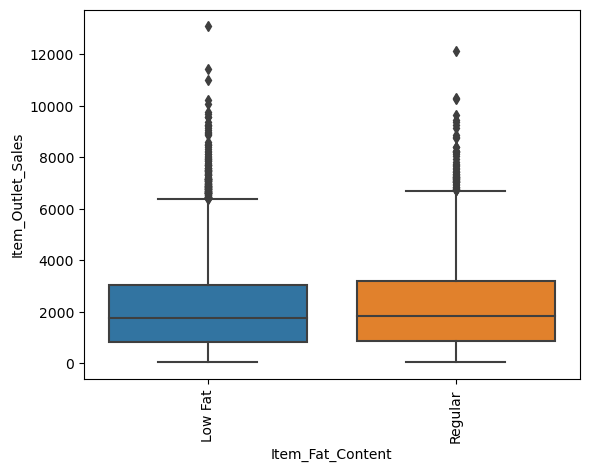

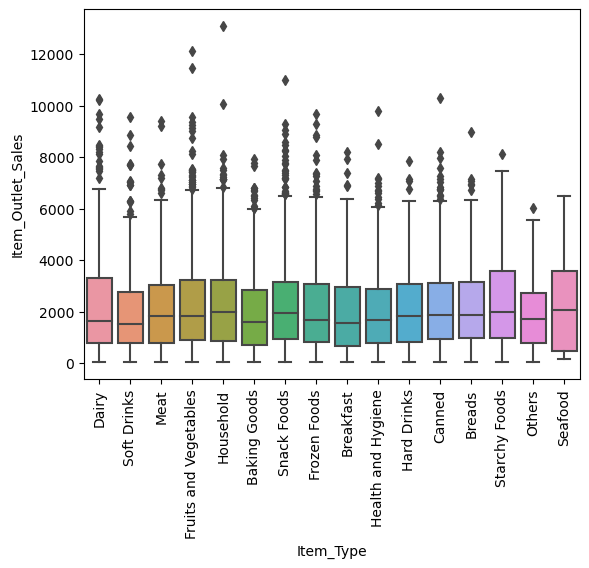

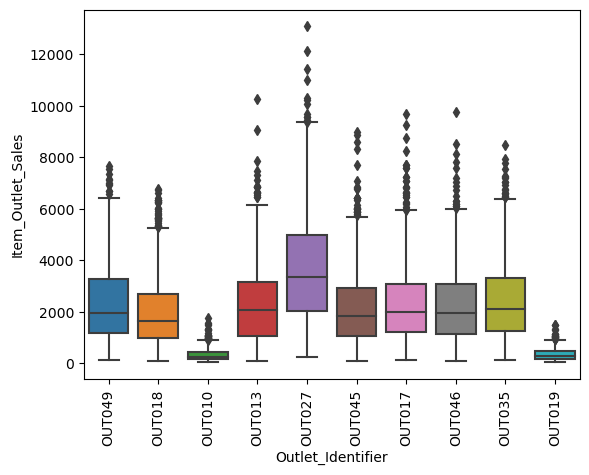

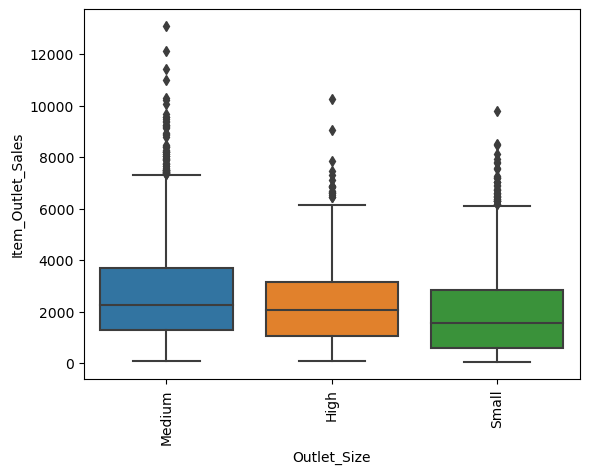

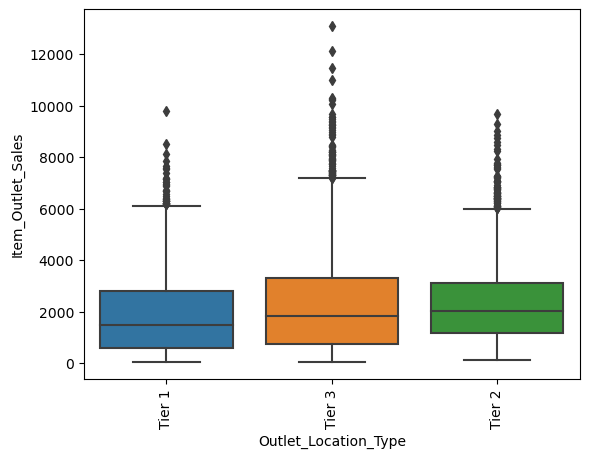

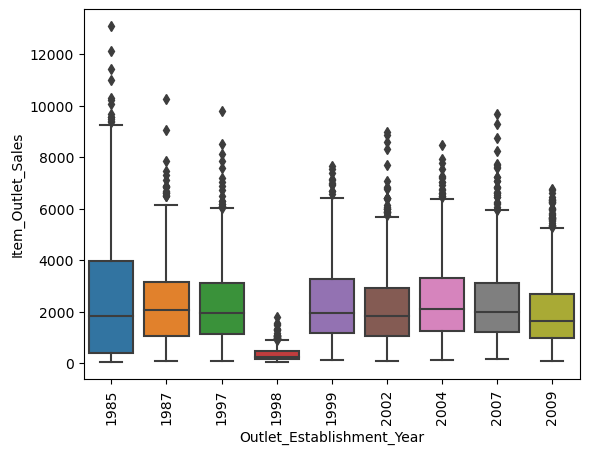

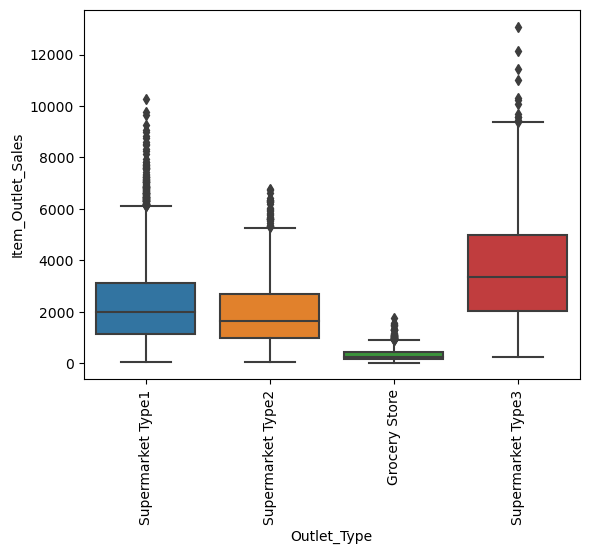

In [12]:
for i in catcols:
    if df[i].nunique()<100:
        sns.boxplot(df[i],df.Item_Outlet_Sales)
        plt.xticks(rotation=90)
        plt.show()

**INFERENCES OF BIVARIATE ANALYSIS OF CATEGORICAL VARIABLES VS TARGET VARIABLE**
* The seafood items were sold for specific prices, no outliers were noticed.
* Dairy and Starchy Foods have highest range in sales prices.
* Outlet 27 was best performing outlet whereas Outlet 10 and 19 were the worst performing outlets.
* Outlets with Medium size and Tier 3 have a higher range of sales.
* Outlet Established in 1998 were among the worst performing outlets. Whereas Outlets established in 1985 has the highest range of sales.
* Grocery Store are not performing well where as Supermarket Type 3 has the highest range of sales.

**BIVARIATE ANALYSIS OF NUMERICAL VARIABLES VS TARGET VARIABLE**

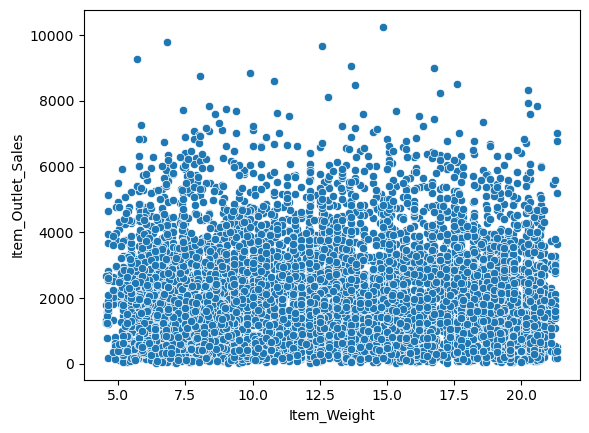

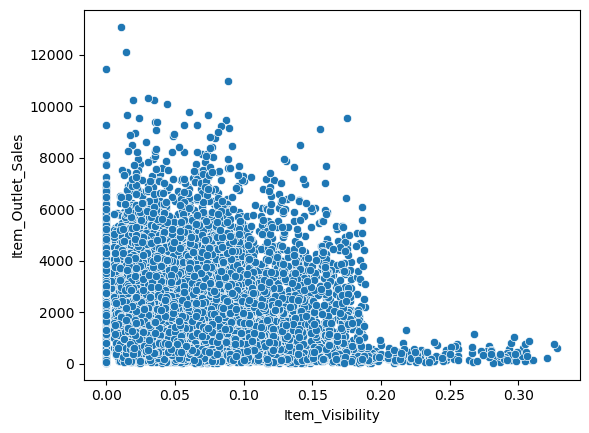

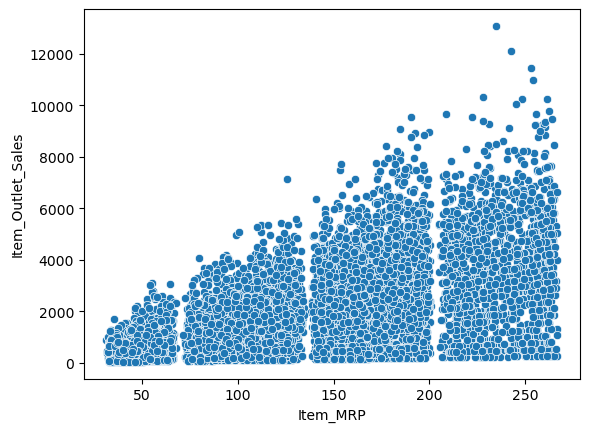

In [13]:
for i in numcols:
    if i!='Item_Outlet_Sales':
        sns.scatterplot(df[i],df['Item_Outlet_Sales'])
        plt.show()

**INFERENCES OF BIVARIATE ANALYSIS OF NUMERICAL VARIABLES VS TARGET VARIABLE**
* Increase in Item Visibility somehow impacts the Item Outlet Sales. They Increase till a point.
* As the Item Price increases, It shows the sales inccrease, that is high MRP means high sales price value.

**TREATING MISSING VALUES**

In [14]:
df.isnull().sum()[df.isnull().sum()>0]

Item_Weight          2439
Outlet_Size          4016
Item_Outlet_Sales    5681
dtype: int64

In [15]:
#Treating the Missing values of Item Weight.

#The Item weight for each specific Item Identifier seems to be exact same.
df['Item_Weight']=df.groupby('Item_Identifier')['Item_Weight'].apply(lambda x: x.fillna(x.mean()))

In [16]:
#treating the missing values of outlet size

#All the outlets in Tier 2 and Outlet Type Supermarket 1 are small or missing,
#therefore they are small as well. Also for Grocery store in a Tier 3 city we can assume that
# they are small in size.

df.loc[df['Outlet_Size'].isnull(),'Outlet_Size']='Small'

In [17]:
#Treating the zeros in Item Visibility

#Items of same Types have almost similar visibility, Therefore filling the zeros with median
# as Item Visibility was a little right skewed.

df['Item_Visibility']=df.groupby('Item_Type')['Item_Visibility'].apply(lambda x: x.fillna(x.median()))

**FEATURE ENGINEERING**

In [18]:
#First extracting Item Categories from Item Identifier

#The first two letters of Item Identifier represents
#whether the Item is food, Drinks or Non-Consumables

fc=[]
for i in df.Item_Identifier:
    fc.append(i[:2])

df['Item_Category']=fc

In [19]:
#Now as there are Non-Consumables, therefore there fat content should be Non-Edible.

df.loc[df.Item_Category=='NC','Item_Fat_Content']='Non Edible'

In [20]:
#Categorizing the Item Types in Perishable or Non Perishables:

perishables=['Dairy','Meat', 'Fruits and Vegetables','Breakfast','Breads', 'Starchy Foods','Seafood']

def Perish(x):
    if x in perishables:
        return('Perishable')
    else:
        return('Non Perishable')
    
df['Product_Category']=df.Item_Type.apply(Perish)

In [21]:
#Price per unit weight of Items

df['Price_PU_Weight']=df.Item_MRP/df.Item_Weight

In [22]:
#Dividing the outlets in three categories based on the frequency of sales

best=['OUT035', 'OUT027','OUT049']
worst=['OUT010','OUT019']
def outlets(x):
    if x in best:
        return('Best')
    elif x in worst:
        return('Poor')
    else:
        return('Good')
    
df['Outlets']=df.Outlet_Identifier.apply(outlets)

In [23]:
# It is 2013 Sales Data. Therefore calculating the age of the Outlet.

df['Outlet_Vintage']=2013-df.Outlet_Establishment_Year

In [24]:
#Computing the Frequency according to the Outlets.

df['Outlet_Freq']=df.Outlet_Identifier.map(df.Outlet_Identifier.value_counts().to_dict())

In [25]:
#Computing the Frequency according to the Item Types

df['Item_Freq']=df.Item_Type.map(df.Item_Type.value_counts().to_dict())

In [26]:
#Computing the Frequency according to the Outlet_Size

df['OutletCount']=df.Outlet_Size.map(df.Outlet_Size.value_counts().to_dict())

In [27]:
#Computing the Frequency according to the Item_Identifier

df['ItemIDCount']=df.Item_Identifier.map(df.Item_Identifier.value_counts().to_dict())

In [28]:
#Dropping the now unnecessary columns:
df.drop(['Item_Identifier','Item_Type','Outlet_Identifier'],axis=1,inplace=True)

**STATISTICAL TESTING OF FEATURES**

In [29]:
#For Categorical Features

model=ols('Item_Outlet_Sales~Item_Fat_Content+Outlet_Size+Outlet_Location_Type+Outlet_Type\
    +Item_Category+Product_Category+Outlets+Outlet_Establishment_Year',df).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
Item_Fat_Content,2.0,9.201502e+06,4.600751e+06,2.083145,1.246014e-01
Outlet_Size,2.0,1.184389e+09,5.921943e+08,268.135927,1.181352e-113
Outlet_Location_Type,2.0,1.419529e+09,7.097646e+08,321.369848,2.823983e-135
Outlet_Type,3.0,3.343020e+09,1.114340e+09,504.554924,8.747049e-302
Item_Category,2.0,2.772459e+07,1.386230e+07,6.276621,1.888456e-03
Product_Category,1.0,1.471593e+07,1.471593e+07,6.663133,9.859352e-03
Outlets,2.0,1.977822e+07,9.889108e+06,4.477627,1.138712e-02
Outlet_Establishment_Year,1.0,1.028892e+07,1.028892e+07,4.658654,3.092529e-02
Residual,8509.0,1.879264e+10,2.208560e+06,NaN,NaN


In [30]:
#For Numerical Features
numcols=df.select_dtypes(include=np.number).columns
for i in numcols:
    if i!='Item_Outlet_Sales':
        print('Shapiro Test of %s:: '%(i),stats.shapiro(df[i]))
        if stats.shapiro(df[i])[1]>0.05:
            print('Levene Test of %s::'%(i),stats.levene(df[i],df.Item_Outlet_Sales))
            if stats.levene(df[i],df.Item_Outlet_Sales)>0.05:
                print('TTest of %s::'%(i),stats.ttest_ind(df[i],df.Item_Outlet_Sales))
            else:
                print('Levene\'s Test Failed. The data has differet variances.')
                print('Mann WhitneyU Test of %s::'%(i),stats.mannwhitneyu(df[i],df.Item_Outlet_Sales))
        else:
            print('Shapiro\'s test failed. The data in not normal')
            print('Mann WhitneyU Test of %s::'%(i),stats.mannwhitneyu(df[i],df.Item_Outlet_Sales))
    print('\n---------------------------------------------------------------------')

Shapiro Test of Item_Weight::  ShapiroResult(statistic=0.9518679976463318, pvalue=0.0)
Shapiro's test failed. The data in not normal
Mann WhitneyU Test of Item_Weight:: MannwhitneyuResult(statistic=nan, pvalue=nan)

---------------------------------------------------------------------
Shapiro Test of Item_Visibility::  ShapiroResult(statistic=0.9127914309501648, pvalue=0.0)
Shapiro's test failed. The data in not normal
Mann WhitneyU Test of Item_Visibility:: MannwhitneyuResult(statistic=nan, pvalue=nan)

---------------------------------------------------------------------
Shapiro Test of Item_MRP::  ShapiroResult(statistic=0.9716829061508179, pvalue=0.0)
Shapiro's test failed. The data in not normal
Mann WhitneyU Test of Item_MRP:: MannwhitneyuResult(statistic=nan, pvalue=nan)

---------------------------------------------------------------------
Shapiro Test of Outlet_Establishment_Year::  ShapiroResult(statistic=0.8725879192352295, pvalue=0.0)
Shapiro's test failed. The data in not 

**INFERENCES OF THE STATISTICAL TESTS**
* All the categorical predictors have a P-value less than 0.05, that is all the predictors are significant.
* The data for the numerical variables is not normal.
* All the numerical predictors are significant as well.